# Task: Model the dynamics of gender in intro CS


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import libraries


import sys
sys.path.append('tools/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplt
import seaborn as sns
import tools
import inputData
   
plt.style.use('ggplot')

## Exploring the Data

Let's go ahead and read in the student dataset first.


In [3]:
dataset = inputData.preprocess()

In [4]:
dataset = dataset.query('gender == "Female" or gender == "Male"')
dataset = dataset.reset_index(drop=True)


print '{:d}{:20}{:d}{:20}'.format(len(dataset.query('gender == "Male"')), ' male students, and ',
                                  len(dataset.query('gender == "Female"')),
                                  ' female students consented to participate in this study')
                        

494 male students, and 388 female students consented to participate in this study


#### Drop the columns that aren't needed for the model

In [5]:
columnsNotNeeded = ['timestamp', 'consent','name', 'name_1', 'name_2', 
                    'morecs','snap_python','hiphop_d1','hiphop_d2','song_ct', 'major'] 
dataset.drop(columnsNotNeeded, axis=1, inplace=True)
                   

### Preprocess feature columns

To prepare our data for classification, we need to devise a scheme to transform all features into numeric data. This dataset as several non-numeric columns that need converting. Many of them are simply `yes`/`no`, e.g. `prcs_2`. We can reasonably convert these into `1`/`0` (binary) values. For the columns whose values are `Nan`, we will convert these to `0`. 


**Note**: These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [6]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['Yes', 'No'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            # e.g. 'reason' => 'reason_class_Interested' , 'reason_class_Other'
            col_data = pd.get_dummies(col_data, prefix=col)

        outX = outX.join(col_data)  # collect column(s) in output dataframe
        outX.fillna(0, inplace=True) # make sure all NaN <missing> values are set to 0

    return outX



In [7]:
dataset = preprocess_features(dataset)
print "Processed feature columns ({}):- {}".format(len(dataset.columns), list(dataset.columns))


Processed feature columns (47):- ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9', 'atcsgender_1', 'atcsgender_2', 'atcsgender_3', 'atcsjob_1', 'atcsjob_2', 'atct_1', 'atct_2', 'atct_3', 'atct_4', 'atct_5', 'atct_6', 'atct_7', 'atct_8', 'blg_1', 'blg_2', 'blg_3', 'blg_4', 'classmtr', 'clet_1', 'clet_2', 'cltrcmp_1', 'cltrcmp_2', 'gender_Female', 'gender_Male', 'grade_B or above', 'grade_B or below', 'mtr_1', 'mtr_2', 'mtr_3', 'prcs_1', 'prcs_2', 'prcs_3', 'prcs_4', 'prcs_5', 'prepared', 'priorcs10', 'reason_class_Interested', 'reason_class_Other']


### Preprocess feature columns - Rename columns

There are some columns that have spaces in their names, these makes it difficult for the tree plotting algorithms that we will be using later to graph these features. As a result, we will change these spaces to hypens.

In [8]:
dataset.rename(columns = {'grade_B or above':'grade_B_or_above'}, inplace = True)
dataset.rename(columns = {'grade_B or below':'grade_B_or_below'}, inplace = True)

## Scaling
Linearly scale each attribute to the range [−1, +1] or [0, 1].



In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#df = dataset

df_scaled = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
dataset = df_scaled
dataset.tail()


,atcs_1,atcs_2,atcs_3,atcs_4,atcs_5,atcs_6,atcs_7,atcs_8,atcs_9,atcsgender_1,...,mtr_3,prcs_1,prcs_2,prcs_3,prcs_4,prcs_5,prepared,priorcs10,reason_class_Interested,reason_class_Other
877,0.933881,0.880304,0.963209,-0.858727,1.317785,0.862523,1.064818,1.494748,0.964702,-0.421723,...,1.051195,1.603387,1.092717,1.581139,1.204159,1.206990,1.935994,-0.217959,0.317999,-0.304855
878,-2.731006,-1.542249,-1.816127,2.890766,-2.543632,-3.178619,-3.018527,-2.134619,-3.231930,-0.421723,...,-0.951298,-0.623680,-0.915150,-0.632456,-0.830455,-0.828507,-1.075552,-0.217959,-3.144660,3.280244
879,0.933881,0.880304,0.963209,0.078646,0.352431,0.862523,1.064818,0.587406,0.964702,-0.421723,...,-0.951298,1.603387,1.092717,-0.632456,1.204159,1.206990,1.935994,-0.217959,-3.144660,-0.304855
880,0.933881,0.880304,0.036764,0.078646,-0.612923,-0.147763,-0.976854,-0.319936,-0.084456,-0.421723,...,-0.951298,-0.623680,-0.915150,-0.632456,-0.830455,-0.828507,-1.075552,-0.217959,0.317999,-0.304855
881,0.017660,-0.330972,-0.889682,0.078646,-1.578278,0.862523,0.043982,-0.319936,0.964702,-0.421723,...,-0.951298,-0.623680,-0.915150,-0.632456,-0.830455,1.206990,-0.322666,-0.217959,0.317999,-0.304855


In [10]:
atcs = ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 
        'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9']# self reported attitude about CS competency
atct = ['atct_1', 'atct_2', 'atct_3', 'atct_4', 
        'atct_5', 'atct_6', 'atct_7', 'atct_8'] # Self reported attitudes about computational thinking
blg = ['blg_1', 'blg_2', 'blg_3', 'blg_4'] # Sense of belonging in the class room
clet = ['clet_1', 'clet_2'] # Social implications and ethics
gender = ['gender_Female', 'gender_Male' ]
atcsgender = ['atcsgender_1','atcsgender_2','atcsgender_3'] 
atcsjob = ['atcsjob_1','atcsjob_2']
clet = ['clet_1','clet_2']
cltrcmp = ['cltrcmp_1','cltrcmp_2']
mtr = ['mtr_1','mtr_2','mtr_3']
prepared = ['prepared']

itemDimensions = {}
itemDimensions['atcs'] = atcs
itemDimensions['atct'] = atct
itemDimensions['blg'] = blg
itemDimensions['gender'] = gender
itemDimensions['atcsgender'] = atcsgender
itemDimensions['atcsjob'] = atcsjob
itemDimensions['clet'] = clet
itemDimensions['cltrcmp'] = cltrcmp
itemDimensions['mtr'] = mtr
itemDimensions['prepared'] = prepared



In [11]:
list_of_lists = [
itemDimensions['atcs'], 
itemDimensions['blg'],
itemDimensions['atct'],
itemDimensions['gender'],
itemDimensions['atcsgender'],
itemDimensions['atcsjob'],
itemDimensions['clet'],
itemDimensions['cltrcmp'],
itemDimensions['mtr'],   
itemDimensions['prepared']
]

flattened = [val for sublist in list_of_lists for val in sublist]

In [12]:
for key in itemDimensions:
    try:
        inputData.describeData(itemDimensions[key])
    except:
        print"{:15}{:20}".format(key, 'Preprocessed feature, no description')

atct_1         I am good at solving a problem by thinking about similar problems I’ve solved before.
atct_2         I have good research skills.
atct_3         I am good at using online search tools.
atct_4         I am persistent at solving puzzles or logic problems.
atct_5         I know how to write computer programs
atct_6         I am good at building things.
atct_7         I’m good at ignoring irrelevant details to solve a problem.
atct_8         I know how to write a computer program to solve a problem.
atcsgender_1   Women are less capable of success in CS than men.
atcsgender_2   Women are smarter than men.
atcsgender_3   Men have better math and science abilities than women.
atcs_1         I like to use computer science to solve problems.
atcs_2         I can learn to understand computing concepts.
atcs_3         I can achieve good grades (C or better) in computing courses.
atcs_4         I do not like using computer science to solve problems.
atcs_5         I am confident th

### Extract features and labels 

Extract feature (X) and target (y) columns

In [13]:
from sklearn.preprocessing import MinMaxScaler

target_col = dataset['gender_Female']  #  column is the target/label 
y = target_col  # corresponding targets/labels


# scale target to binary so that we can use in estimators
scaler = MinMaxScaler()

y_scaled = pd.DataFrame(scaler.fit_transform(y.reshape(-1, 1)))
y = y_scaled



print "\nLabel values:-"
print y.head()  


Label values:-
     0
0  1.0
1  1.0
2  1.0
3  1.0
4  1.0


In [14]:
X = dataset.drop(['gender_Female', 'gender_Male'], axis=1, inplace=False)

print "\nFeature values:-"
print X.head()  


Feature values:-
     atcs_1    atcs_2    atcs_3    atcs_4    atcs_5    atcs_6    atcs_7  \
0 -0.898562 -0.330972  0.963209  1.016019  0.352431 -0.147763  0.043982   
1 -2.731006 -3.964803 -2.742573  2.890766 -2.543632 -3.178619 -3.018527   
2  0.933881  0.880304  0.963209 -0.858727  1.317785  0.862523  1.064818   
3  0.933881 -0.330972  0.036764 -0.858727  0.352431 -0.147763  0.043982   
4 -0.898562 -1.542249  0.036764  0.078646 -0.612923 -0.147763  1.064818   

     atcs_8    atcs_9  atcsgender_1         ...             mtr_3   prcs_1  \
0 -0.319936 -0.084456     -0.421723         ...         -0.951298 -0.62368   
1 -2.134619 -2.182772     -0.421723         ...         -0.951298 -0.62368   
2  1.494748  0.964702     -0.421723         ...          1.051195 -0.62368   
3  1.494748  0.964702     -0.421723         ...         -0.951298 -0.62368   
4 -1.227277 -0.084456     -0.421723         ...         -0.951298 -0.62368   

    prcs_2    prcs_3    prcs_4    prcs_5  prepared  priorcs10 

### Exploratory Visualization
- As we can see the dataset is unbalanced, we have more males than females.




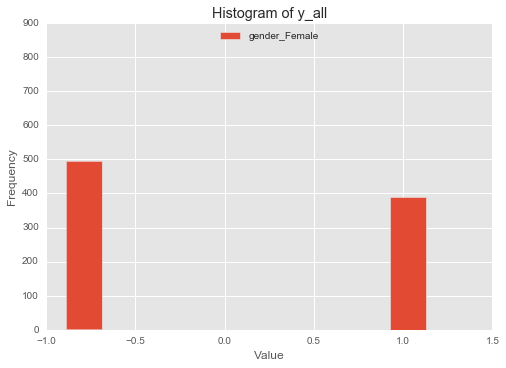

In [15]:
y.plot.hist()

_= pyplt.xlabel('Value')
_= pyplt.title('Histogram of y_all')
_= pyplt.legend(loc='upper center', shadow=True, fontsize='medium')
_= pyplt.yticks(np.arange(0, 1000, 100))


In [16]:
## Make sure we drop the target from the table, otherwise we will be including the labeled data

print "Feature column(s):-", list(X)

Feature column(s):- ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9', 'atcsgender_1', 'atcsgender_2', 'atcsgender_3', 'atcsjob_1', 'atcsjob_2', 'atct_1', 'atct_2', 'atct_3', 'atct_4', 'atct_5', 'atct_6', 'atct_7', 'atct_8', 'blg_1', 'blg_2', 'blg_3', 'blg_4', 'classmtr', 'clet_1', 'clet_2', 'cltrcmp_1', 'cltrcmp_2', 'grade_B_or_above', 'grade_B_or_below', 'mtr_1', 'mtr_2', 'mtr_3', 'prcs_1', 'prcs_2', 'prcs_3', 'prcs_4', 'prcs_5', 'prepared', 'priorcs10', 'reason_class_Interested', 'reason_class_Other']


## Feature Transformation
We will use principal component analysis (PCA) to draw conclusions about the underlying structure of the data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe students.

In [17]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA

pca_data = dataset.drop(['gender_Female', 'gender_Male'], axis=1, inplace=False)

pca = PCA(n_components=3)
pca.fit(pca_data)

# Generate PCA results plot
pca_results = tools.pca_results(pca_data, pca)

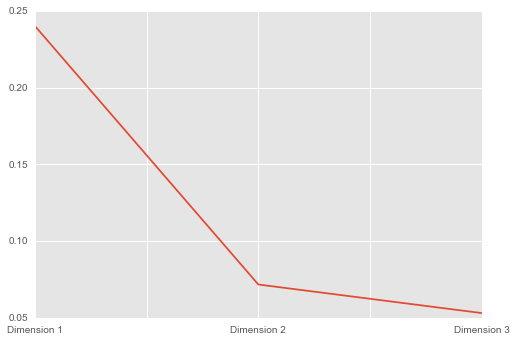

In [18]:
pca_results['Explained Variance'].plot();

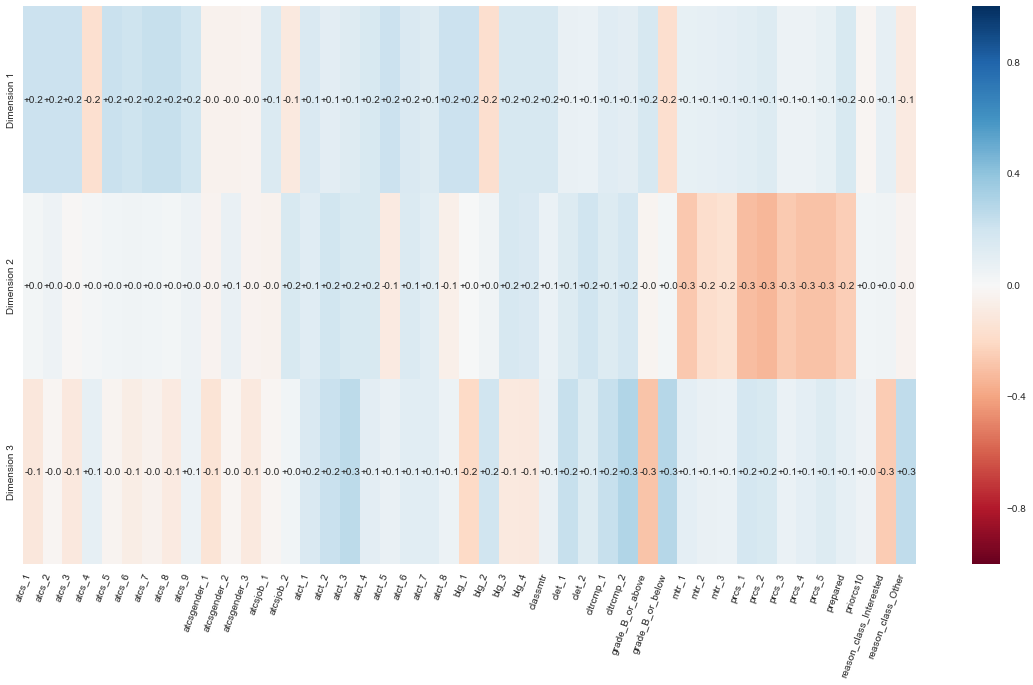

In [19]:
cols = [col for col in pca_results.columns if col not in ['Explained Variance']]
df2 = pca_results[cols]

myFileName='report/figures' + '/' + 'pcaStudentData' +'.png'
rcParams['figure.figsize'] = 20, 10
fig = figure(dpi=80) # no frame

with sns.axes_style("white"):
    ax = sns.heatmap(df2, square=False, annot=True, vmin=-1, vmax=1, cmap='RdBu', fmt='+.1f')
    plt.xticks(rotation=70, ha='right');
    

In [20]:
from time import time


print("Projecting the input data on the eigenfaces orthonormal basis")
X_all_pca = pca.transform(X)

Projecting the input data on the eigenfaces orthonormal basis


In [21]:
X_all_pca = pd.DataFrame(X_all_pca)
X_all_pca.columns = ['pca_1', 'pca_2', 'pca_3']
X_all_pca.head()

,pca_1,pca_2,pca_3
0,-0.448809,1.087570,-0.688542
1,-9.491030,-1.597040,2.134180
2,3.193847,0.813628,-0.060628
3,1.729576,0.734111,0.049023
4,-1.678727,2.671373,-0.147392


In [22]:

X_all = X
X_all['pca_1'] = X_all_pca['pca_1']
X_all['pca_2'] = X_all_pca['pca_2']
X_all['pca_3'] = X_all_pca['pca_3']

In [23]:
# First, decide how many training vs test samples you want
num_all = X.shape[0]  # same as len(student_data)
num_train = 662  # about 75% of the data
num_test = num_all - num_train

In [24]:
num_train

662

In [25]:
from sklearn import cross_validation



def shuffle_split_data(X, y):
    """ Shuffles and splits data into 75% training and 25% testing subsets,
        then returns the training and testing subsets. """
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, 
                                                                        train_size=num_train, random_state=42)
    
    
    


    # Return the training and testing data subsets
    return X_train, y_train, X_test, y_test

In [26]:
try:
    X_train, y_train, X_test, y_test = shuffle_split_data(X, y)
    print "Successfully shuffled and split the data!"
except:
    print "Something went wrong with shuffling and splitting the data."


print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Successfully shuffled and split the data!
Training set: 662 samples
Test set: 220 samples


## Modeling and Validating




I have created four separate tranches to investigate the data:
- All features
- All features with the addition of PCA transformed features
- A reduced dataset of features
- All features with the exception of gendered features removed

In [30]:
y_train

292   -0.886242
596    1.128360
516   -0.886242
447   -0.886242
813    1.128360
767   -0.886242
212    1.128360
837   -0.886242
79     1.128360
148   -0.886242
417    1.128360
519   -0.886242
643    1.128360
382   -0.886242
617   -0.886242
368   -0.886242
433   -0.886242
133   -0.886242
846   -0.886242
165    1.128360
535   -0.886242
55     1.128360
734   -0.886242
862    1.128360
537   -0.886242
359    1.128360
457    1.128360
204    1.128360
603   -0.886242
487   -0.886242
         ...   
160   -0.886242
276    1.128360
191    1.128360
385   -0.886242
805   -0.886242
413    1.128360
491   -0.886242
343   -0.886242
769   -0.886242
308    1.128360
661    1.128360
130   -0.886242
663   -0.886242
99    -0.886242
372    1.128360
87     1.128360
458   -0.886242
330   -0.886242
214   -0.886242
466   -0.886242
121   -0.886242
614   -0.886242
20     1.128360
700    1.128360
71     1.128360
106   -0.886242
270    1.128360
860   -0.886242
435   -0.886242
102   -0.886242
Name: gender_Female, dty

## Train on all features

In [27]:
X = X_train.drop(['pca_1','pca_2','pca_3'], axis=1, inplace=False)
print "\nFeature values:-"
print X.head() 


Feature values:-
       atcs_1    atcs_2    atcs_3    atcs_4    atcs_5    atcs_6    atcs_7  \
292  0.933881  0.880304  0.036764 -0.858727  0.352431  0.862523  1.064818   
596  0.017660 -0.330972  0.036764  0.078646  0.352431 -0.147763  0.043982   
516  0.933881  0.880304  0.963209 -0.858727  0.352431  0.862523  0.043982   
447  0.017660 -0.330972  0.036764  1.016019  0.352431 -0.147763  0.043982   
813  0.933881 -0.330972 -0.889682 -0.858727  0.352431  0.862523  0.043982   

       atcs_8    atcs_9  atcsgender_1         ...             mtr_3    prcs_1  \
292 -0.319936 -0.084456     -0.421723         ...         -0.951298 -0.623680   
596  0.587406 -0.084456     -0.421723         ...         -0.951298  1.603387   
516  0.587406 -0.084456     -0.421723         ...         -0.951298 -0.623680   
447  0.587406 -0.084456     -0.421723         ...          1.051195  1.603387   
813  0.587406 -0.084456     -0.421723         ...          1.051195 -0.623680   

       prcs_2    prcs_3    prcs_

In [28]:

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score


models = {
          'XGBoost': XGBClassifier()
         }


In [29]:
for model_name, model in models.iteritems():
    print model_name
    kfold = StratifiedKFold(y_train, n_folds=50, random_state=7)
    results = cross_val_score(model, X, y_train, cv=kfold)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)), '\n'
    

XGBoost


ValueError: continuous is not supported

In [ ]:
print model

In [ ]:
model.fit(X, y_train)
g = xgb.to_graphviz(model, rankdir='LR')
g.render('report/figures/X_graph.gv', view=True)
    

### Predict 

In [ ]:
Features_test = X_test.drop(['pca_1','pca_2','pca_3'], axis=1, inplace=False)


# make predictions for test data
y_pred = model.predict(Features_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#### Generate Features from XGBoost classifier 

In [ ]:
# plot feature importance
from xgboost import plot_importance


model.fit(X, y_train)
plot_importance(model)
pyplot.show()

## Train on a reduced set of features

In [ ]:
# Extract feature (X) and target (y) columns


X_all_Reduced = X_train[['pca_2', 'pca_3', 'pca_1', 
                'atcsgender_2', 'atcsgender_3', 
                'atcs_1', 'atcs_8',
                'cltrcmp_2', 'atcsjob_2', 'clet_2', 'atct_3',
                'blg_1', 'atcsgender_1']]


print "\nFeature values:-"
print X_all_Reduced.head()  

In [ ]:
for model_name, model in models.iteritems():
    print model_name
    kfold = StratifiedKFold(y_train, n_folds=50, random_state=7)
    results = cross_val_score(model, X_all_Reduced, y_train, cv=kfold)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)), '\n'



In [ ]:
model.fit(X_all_Reduced, y_train)
g = xgb.to_graphviz(model, rankdir='LR')
g.render('report/figures/X_all_Reduced_graph.gv', view=True)

In [ ]:
Features_test = X_test[['pca_2', 'pca_3', 'pca_1', 
                'atcsgender_2', 'atcsgender_3', 
                'atcs_1', 'atcs_8',
                'cltrcmp_2', 'atcsjob_2', 'clet_2', 'atct_3',
                'blg_1', 'atcsgender_1']]


# make predictions for test data
y_pred = model.predict(Features_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

## Train on features with the exception of gendered features 

In [ ]:
X_all_No_Gender = X_train.drop(['pca_1','pca_2','pca_3','atcsgender_1','atcsgender_2','atcsgender_3',], 
                            axis=1, inplace=False)


print "\nFeature values:-"
print X_all_No_Gender.head()  

In [ ]:
for model_name, model in models.iteritems():
    print model_name
    kfold = StratifiedKFold(y_train, n_folds=50, random_state=7)
    results = cross_val_score(model, X_all_No_Gender, y_train, cv=kfold)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)), '\n'


In [ ]:
model.fit(X_all_No_Gender, y_train)
g = xgb.to_graphviz(model, rankdir='LR')
g.render('report/figures/X_all_No_Gender_graph.gv', view=True)

In [ ]:
Features_test = X_test.drop(['pca_1','pca_2','pca_3','atcsgender_1','atcsgender_2','atcsgender_3',], 
                            axis=1, inplace=False)


# make predictions for test data
y_pred = model.predict(Features_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

## Train on all data including PCA

In [ ]:
X_all = X_train


print "\nFeature values:-"
print X_all.head()  

In [ ]:
for model_name, model in models.iteritems():
    print model_name
    kfold = StratifiedKFold(y_train, n_folds=50, random_state=7)
    results = cross_val_score(model, X_all, y_train, cv=kfold)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)), '\n'


In [ ]:
model.fit(X_all, y_train)
g = xgb.to_graphviz(model, rankdir='LR')
g.render('report/figures/X_all_graph.gv', view=True)

In [ ]:
Features_test = X_test


# make predictions for test data
y_pred = model.predict(Features_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

## Investigate important features

In [ ]:

pre_males = dataset.query('gender_Female == 0')
pre_males = pre_males[['atcs_1']]

axes = pre_males.plot.hist()
axes.set_xlabel('Male Students')
axes.set_title('Measurement of atcs_1:"I like to use computer science to solve problems"')
axes.set_yticks(np.arange(0, 300, 50))


a=axes.get_xticks().tolist()
a[0] = 'Strongly Disagree'
a[1] = 'Disagree'
a[3] = 'Neutral'
a[4] = 'Agree'
a[5] = 'Strongly Agree'
axes.set_xticklabels(a);

In [ ]:
pre_females = dataset.query('gender_Female == 1')
pre_females = pre_females[['atcs_1']]

axes = pre_females.plot.hist()
axes.set_xlabel('Female Students')
axes.set_title('Measurement of atcs_1:"I like to use computer science to solve problems"')
axes.set_yticks(np.arange(0, 300, 50))


a=axes.get_xticks().tolist()
a[0] = 'Strongly Disagree'
a[1] = 'Disagree'
a[3] = 'Neutral'
a[4] = 'Agree'
a[5] = 'Strongly Agree'
axes.set_xticklabels(a);

## Tune Estimator

### Ideal choices of parameters as taken from Xgboost With Python ebook

- Number of Trees (n estimators) set to a fixed value between 100 and 1000, depending on the dataset size.
- Learning Rate (learning rate) simplified to the ratio: [2 to 10]/trees, depending on the trees number of trees.
- Row Sampling (subsample) grid searched values in the range [0.5, 0.75, 1.0].
- Column Sampling (colsample bytree and maybe colsample bylevel) grid searched values in the range [0.4, 0.6, 0.8, 1.0].
- Min Leaf Weight (min child weight) simplified to the ratio 3/rare_events , where rare events rare events is the percentage of rare event observations in the dataset.
- Tree Size (max depth) grid searched values in the rage [4, 6, 8, 10].
- Min Split Gain (gamma) fixed with a value of zero.


In [ ]:
from __future__ import division


trees = range(100, 1000, 100)

lRate = range(2, 10, 2)
lRate = [x/9 for x in lRate]
X = X_train.drop(['pca_1','pca_2','pca_3'], axis=1, inplace=False)

In [ ]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import f1_score, make_scorer
from xgboost import XGBClassifier as XGBC



print '_'*20, 'Tuning XGBoost', '_'*20
print "Training the data"


# max_delta_step, Maximum delta step we allow each tree's weight estimation to be. 
# If the value is set to 0, it means there is no constraint. If it is set to a positive value, 
# it can help making the update step more conservative. Usually this parameter is not needed, 
# but it might help in logistic regression when class is extremely imbalanced. 
# Set it to value of 1-10 might help control the update

cv_params = {'learning_rate': [0.2222, 0.4444, 0.6666, 0.8888],
            'max_depth': [4, 6, 8, 10],
            'n_estimators': range(100, 1100, 100)}
             



# Build a stratified shuffle object because of unbalanced data
folds = 50
ssscv = StratifiedShuffleSplit(y_train, folds, random_state = 42)

# Make an appropriate scoring function
scoring_function = make_scorer(f1_score)


grid = GridSearchCV(XGBC(), cv_params, cv=ssscv, scoring=scoring_function, n_jobs = -1) 
grid.fit(X, y_train)


In [ ]:
model =  grid.best_estimator_
print model

In [ ]:
print model

Features_test = X_test.drop(['pca_1','pca_2','pca_3'], axis=1, inplace=False)


# make predictions for test data
y_pred = model.predict(Features_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

## Save Model

In [ ]:
import pickle

# save model to file
pickle.dump(model, open("genderedCSExperience.pickle.dat", "wb"))

In [ ]:
model.fit(X, y_train)
g = xgb.to_graphviz(model, rankdir='LR')
g.render('report/figures/Tuned_model_graph.gv', view=True)